# Import Necessary Libraries

In [1]:
import numpy

In [3]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from albumentations import (
    HorizontalFlip, RandomBrightnessContrast, RandomCrop, Resize, Compose
)
from albumentations.pytorch import ToTensorV2
import json
import random
from PIL import ImageFilter
from PIL import ImageOps
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.rpn import AnchorGenerator
import torch


# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from vision.references.detection.engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
from Augmentations import *
from Collector import *
from ExtractBoxesandLabels import *
from CityScapesDatasetCreator import *
from Categories_info import *
from BasedSupervisedModel import *

# Define Dataset Class

In [5]:

def collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets


In [6]:


# Paths
train_image_dir = "../Datasets/leftImg8bit/train/all_data"
train_instance_dir = "../Datasets/gtFine/train/all_data"
val_image_dir = "../Datasets/leftImg8bit/val/all_data"
val_instance_dir = "../Datasets/gtFine/val/all_data"



train_augmentations = build_strong_augmentation(True)
val_augmentations = build_strong_augmentation(False)

# Initialize the dataset
train_dataset = CityscapesBBoxDataset(
    image_dir=train_image_dir,
    instance_dir=train_instance_dir,
    json_dir=train_instance_dir,
    instance_classes=instance_classes,
    class_to_category=class_to_category,
    category_map=category_map,
    transform=train_augmentations
)

# Initialize the dataset
val_dataset = CityscapesBBoxDataset(
    image_dir=val_image_dir,
    instance_dir=val_instance_dir,
    json_dir=val_instance_dir,
    instance_classes=instance_classes,
    class_to_category=class_to_category,
    category_map=category_map,
    transform=val_augmentations
)
BATCH_SIZE=4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)
# Test dataset


In [7]:
for image, target in train_loader:
    #print("Image size:", image)
    print("Target:", target)
    

    #print("Category Labels:", target["category_labels"])
    break

Target: ({'boxes': tensor([[ 152.9297,    0.0000,  965.6250,  267.1875],
        [ 575.9766,  195.1172,  640.4297,  239.6484],
        [   0.0000,  233.2031, 1199.4141,  599.4141],
        [ 685.5469,  257.8125, 1199.4141,  444.7266],
        [ 611.1328,  227.9297,  630.4688,  236.1328],
        [ 623.4375,  233.2031,  631.0547,  237.8906],
        [ 601.7578,  226.7578,  618.1641,  236.1328],
        [ 530.2734,  182.8125,  604.1016,  257.8125],
        [ 637.5000,  228.5156,  695.5078,  261.3281],
        [ 669.1406,  104.2969,  715.4297,  251.3672],
        [ 636.3281,  213.8672,  722.4609,  286.5234],
        [ 586.5234,  235.5469,  595.3125,  241.9922],
        [ 616.9922,  143.5547,  716.0156,  257.2266],
        [ 649.2188,  208.5938,  652.1484,  253.1250],
        [ 532.6172,  173.4375,  570.7031,  238.4766],
        [ 645.7031,  208.0078,  648.0469,  250.7812],
        [ 368.5547,   29.2969,  555.4688,  275.3906],
        [ 638.0859,  246.0938,  650.3906,  254.2969],
        [

# Lets See Some Images and Their Labels

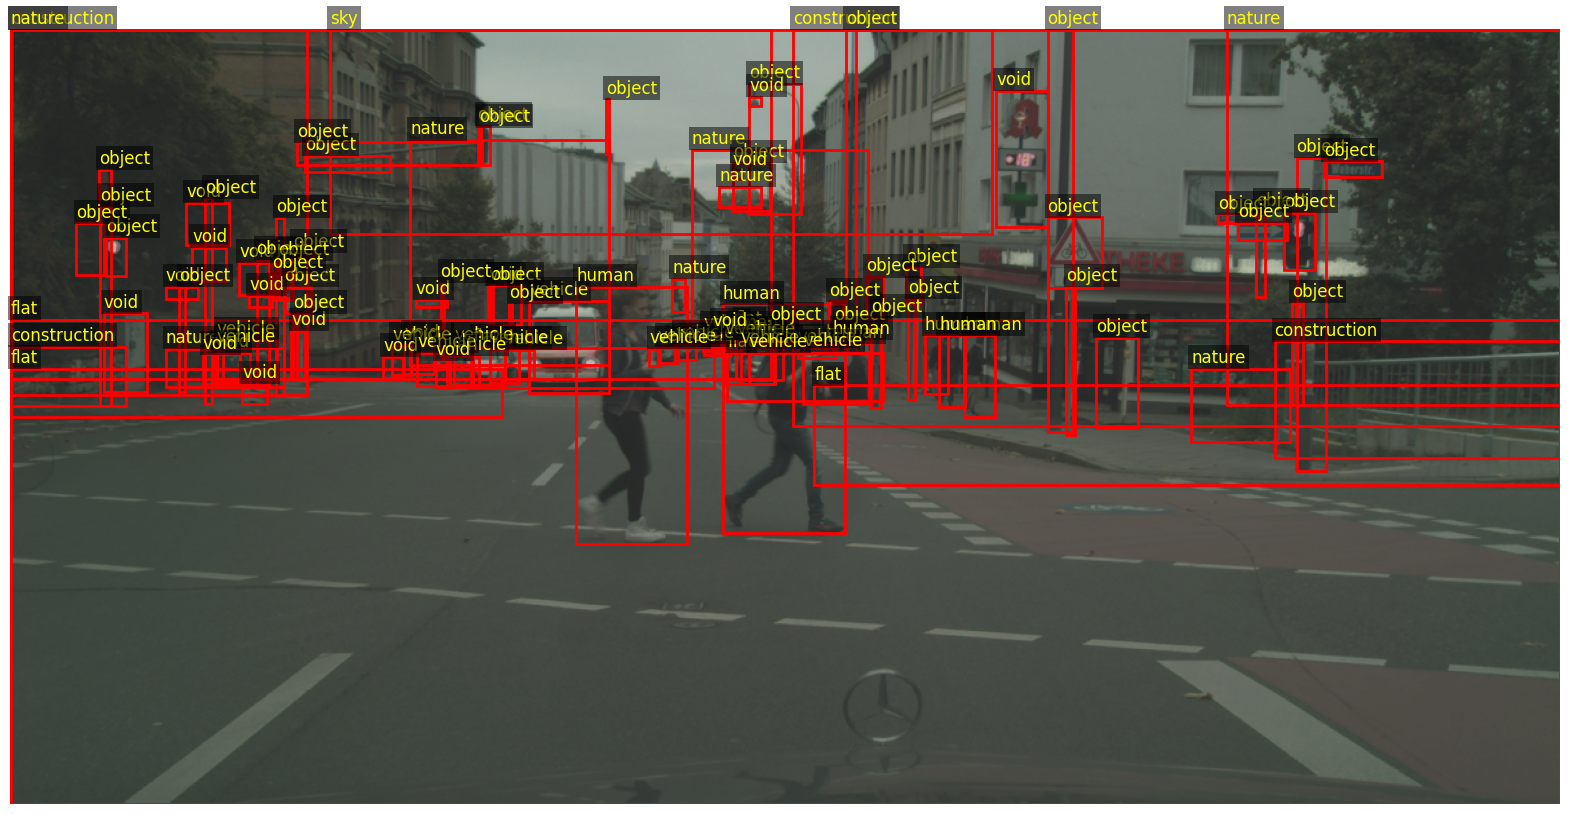

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch  # Ensure torch is imported if dealing with tensors
classes={0: 'flat',
 1: 'construction',
 2: 'nature',
 3: 'vehicle',
 4: 'sky',
 5: 'object',
 6: 'human',
 7: 'void'}
def plot_img_bbox(img, target):
    """
    Plots an image with bounding boxes and their associated labels.

    Args:
        img (np.ndarray or torch.Tensor): The image to plot.
        target (dict): Dictionary containing 'boxes' (list of [xmin, ymin, xmax, ymax]) and 'labels'.

    """
    # Convert the image from (C, H, W) to (H, W, C) if it's a PyTorch tensor
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()

    # Normalize the image values if they are not in the range [0, 1]
    if img.max() > 1:
        img = img / 255.0

    # Plot the image and bounding boxes
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(20, 20)
    a.imshow(img)

    # Iterate over bounding boxes and labels
    for box, label in zip(target['boxes'], target['labels']):
        # Extract box coordinates
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        a.add_patch(rect)  # Add the rectangle to the plot

        # Add label text above the bounding box
        a.text(
            x_min,
            y_min - 5,  # Slightly above the top-left corner
            str(classes[label.item()]),  # Convert label to string
            color='yellow',
            fontsize=12,
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2)  # Background for better visibility
        )

    plt.axis("off")  # Turn off axes
    plt.show()

img, target = train_dataset[65]
#print(img[0])
plot_img_bbox(img, target)

# Supervised Modelling Class 

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import logging


# Configure logging
logging.basicConfig(
    filename='Model_Results/training.log', 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FasterRCNNModel(num_classes=8).to(device)
#model.load_state_dict(torch.load("./Model_Results/faster_rcnn_model_2_result.pth"))
# Optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

# Load training state
if os.path.exists("./Model_Results/checkpoint.pth"):
    checkpoint = torch.load("./Model_Results/checkpoint.pth")
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch=0


# Initialize lists to store losses

# Training and validation loop
num_epochs = 50  # Number of epochs
number_of_data_run=10
train_losses = []
val_losses = []
logging.info("Training started.")
for epoch in range(start_epoch,start_epoch+num_epochs):
    logging.info(f"Epoch {epoch + 1}/{start_epoch + num_epochs}")
    print(f"\nEpoch {epoch + 1}/{start_epoch + num_epochs}")
    print("-" * 20)
    # Training phase
    model.train()
    train_loss = 0.0
    
    for i,(images, targets) in enumerate(tqdm(train_loader, desc="Training")):
        # Move data to device
        if i<number_of_data_run:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            
            loss_dict = model(images, targets)
            logging.info(str(loss_dict))
            losses = sum(loss for loss in loss_dict.values())
        
            train_loss += losses.item() 
                                    # Backward pass
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()    
            
        else:
            break

    avg_train_loss = train_loss / number_of_data_run
    logging.info(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)
    model.eval()
    logging.info("Validation evaluation started.")
    val_loss=0.0
    for i,(images, targets) in enumerate(tqdm(val_loader, desc="Validation")):
        # Move data to device
        if i<number_of_data_run:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            model.train()
            
            
            with torch.no_grad(): # No gradients
                loss_dict = model(images, targets)
                logging.info(f"Validation Losses: {loss_dict}")  # Log individual losses
                losses = sum(loss for loss in loss_dict.values())
                
                val_loss += losses.item() 
            
        else:
            break
    avg_val_loss = val_loss / number_of_data_run
    logging.info(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)
    
torch.save({
    'epoch': epoch,
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
}, "./Model_Results/checkpoint.pth")
if os.path.exists('Model_Results/Loses_info.csv'):
    pd.concat([pd.read_csv('Model_Results/Loses_info.csv'),pd.DataFrame({'Train Loss Value':train_losses,'Validation Loss Value':val_losses})]).to_csv('Model_Results/Loses_info.csv',index=False)
else:
    pd.DataFrame({'Train Loss Value':train_losses,'Validation Loss Value':val_losses}).to_csv('Model_Results/Loses_info.csv',index=False)

logging.info(f"Training completed for all epochs !")
print(f"Training completed for all epochs !")




Epoch 61/110
--------------------


Training:   1%|▏         | 10/744 [10:18<12:36:18, 61.82s/it]


Training Loss: 13.1018


Validation:   8%|▊         | 10/125 [03:53<44:50, 23.39s/it]


Validation Loss: 15.0936

Epoch 62/110
--------------------


Training:   1%|▏         | 10/744 [11:52<14:31:40, 71.25s/it]


Training Loss: 14.0124


Validation:   8%|▊         | 10/125 [03:20<38:22, 20.02s/it]


Validation Loss: 14.0239

Epoch 63/110
--------------------


Training:   1%|▏         | 10/744 [08:04<9:52:20, 48.42s/it]


Training Loss: 12.2323


Validation:   8%|▊         | 10/125 [02:10<25:03, 13.07s/it]


Validation Loss: 13.2844

Epoch 64/110
--------------------


Training:   1%|▏         | 10/744 [06:19<7:44:31, 37.97s/it]


Training Loss: 14.0163


Validation:   8%|▊         | 10/125 [01:55<22:12, 11.59s/it]


Validation Loss: 14.0524

Epoch 65/110
--------------------


Training:   1%|▏         | 10/744 [05:47<7:05:17, 34.77s/it]


Training Loss: 14.3540


Validation:   8%|▊         | 10/125 [01:55<22:10, 11.57s/it]


Validation Loss: 13.5999

Epoch 66/110
--------------------


Training:   1%|▏         | 10/744 [05:47<7:05:26, 34.78s/it]


Training Loss: 13.6994


Validation:   8%|▊         | 10/125 [01:57<22:29, 11.73s/it]


Validation Loss: 15.1892

Epoch 67/110
--------------------


Training:   1%|▏         | 10/744 [05:47<7:04:53, 34.73s/it]


Training Loss: 12.9024


Validation:   8%|▊         | 10/125 [01:55<22:04, 11.51s/it]


Validation Loss: 13.9090

Epoch 68/110
--------------------


Training:   1%|▏         | 10/744 [05:46<7:03:47, 34.64s/it]


Training Loss: 13.5921


Validation:   8%|▊         | 10/125 [01:56<22:21, 11.67s/it]


Validation Loss: 14.6694

Epoch 69/110
--------------------


Training:   1%|▏         | 10/744 [09:57<12:10:44, 59.73s/it]


Training Loss: 12.8148


Validation:   8%|▊         | 10/125 [03:32<40:42, 21.24s/it]


Validation Loss: 14.2175

Epoch 70/110
--------------------


Training:   1%|▏         | 10/744 [10:45<13:09:45, 64.56s/it]


Training Loss: 13.0085


Validation:   8%|▊         | 10/125 [03:33<40:51, 21.32s/it]


Validation Loss: 14.2504

Epoch 71/110
--------------------


Training:   1%|▏         | 10/744 [10:47<13:12:12, 64.76s/it]


Training Loss: 13.2393


Validation:   8%|▊         | 10/125 [03:32<40:42, 21.24s/it]


Validation Loss: 13.9075

Epoch 72/110
--------------------


Training:   1%|▏         | 10/744 [10:56<13:23:39, 65.69s/it]


Training Loss: 11.6219


Validation:   8%|▊         | 10/125 [03:35<41:21, 21.58s/it]


Validation Loss: 14.4119

Epoch 73/110
--------------------


Training:   1%|▏         | 10/744 [10:58<13:26:03, 65.89s/it]


Training Loss: 13.7140


Validation:   8%|▊         | 10/125 [03:38<41:54, 21.87s/it]


Validation Loss: 12.8031

Epoch 74/110
--------------------


Training:   1%|▏         | 10/744 [10:52<13:18:05, 65.24s/it]


Training Loss: 14.0904


Validation:   8%|▊         | 10/125 [03:41<42:24, 22.13s/it]


Validation Loss: 13.9526

Epoch 75/110
--------------------


Training:   1%|▏         | 10/744 [10:56<13:23:35, 65.69s/it]


Training Loss: 14.0567


Validation:   8%|▊         | 10/125 [03:34<41:11, 21.49s/it]


Validation Loss: 13.7835

Epoch 76/110
--------------------


Training:   1%|▏         | 10/744 [10:55<13:21:42, 65.53s/it]


Training Loss: 13.8039


Validation:   8%|▊         | 10/125 [03:32<40:40, 21.22s/it]


Validation Loss: 13.6670

Epoch 77/110
--------------------


Training:   1%|▏         | 10/744 [10:53<13:19:09, 65.33s/it]


Training Loss: 13.9257


Validation:   8%|▊         | 10/125 [03:35<41:21, 21.58s/it]


Validation Loss: 13.3004

Epoch 78/110
--------------------


Training:   1%|▏         | 10/744 [11:31<14:06:09, 69.17s/it]


Training Loss: 13.5073


Validation:   8%|▊         | 10/125 [03:41<42:32, 22.20s/it]


Validation Loss: 14.7567

Epoch 79/110
--------------------


Training:   1%|▏         | 10/744 [11:08<13:38:21, 66.90s/it]


Training Loss: 12.6418


Validation:   8%|▊         | 10/125 [03:41<42:27, 22.16s/it]


Validation Loss: 14.5821

Epoch 80/110
--------------------


Training:   1%|▏         | 10/744 [11:15<13:46:46, 67.58s/it]


Training Loss: 14.3393


Validation:   8%|▊         | 10/125 [03:38<41:48, 21.81s/it]


Validation Loss: 14.2076

Epoch 81/110
--------------------


Training:   1%|▏         | 10/744 [10:55<13:21:56, 65.55s/it]


Training Loss: 13.9729


Validation:   8%|▊         | 10/125 [03:39<42:05, 21.96s/it]


Validation Loss: 13.6028

Epoch 82/110
--------------------


Training:   1%|▏         | 10/744 [10:59<13:26:51, 65.96s/it]


Training Loss: 14.3822


Validation:   8%|▊         | 10/125 [03:37<41:42, 21.76s/it]


Validation Loss: 14.3416

Epoch 83/110
--------------------


Training:   1%|▏         | 10/744 [10:55<13:21:31, 65.52s/it]


Training Loss: 14.4071


Validation:   8%|▊         | 10/125 [03:34<41:03, 21.42s/it]


Validation Loss: 13.5919

Epoch 84/110
--------------------


Training:   1%|▏         | 10/744 [10:57<13:23:48, 65.71s/it]


Training Loss: 13.5136


Validation:   8%|▊         | 10/125 [03:39<42:05, 21.96s/it]


Validation Loss: 13.7684

Epoch 85/110
--------------------


Training:   1%|▏         | 10/744 [10:57<13:24:11, 65.74s/it]


Training Loss: 12.5815


Validation:   8%|▊         | 10/125 [03:35<41:13, 21.51s/it]


Validation Loss: 15.3020

Epoch 86/110
--------------------


Training:   1%|▏         | 10/744 [10:53<13:20:03, 65.40s/it]


Training Loss: 13.8158


Validation:   8%|▊         | 10/125 [03:37<41:41, 21.75s/it]


Validation Loss: 14.6903

Epoch 87/110
--------------------


Training:   1%|▏         | 10/744 [11:00<13:27:32, 66.01s/it]


Training Loss: 12.9177


Validation:   8%|▊         | 10/125 [03:41<42:27, 22.15s/it]


Validation Loss: 13.9530

Epoch 88/110
--------------------


Training:   1%|▏         | 10/744 [11:07<13:36:07, 66.71s/it]


Training Loss: 13.1395


Validation:   8%|▊         | 10/125 [03:40<42:18, 22.07s/it]


Validation Loss: 12.8171

Epoch 89/110
--------------------


Training:   1%|▏         | 10/744 [11:30<14:04:40, 69.05s/it]


Training Loss: 13.5030


Validation:   8%|▊         | 10/125 [03:39<42:04, 21.95s/it]


Validation Loss: 13.2771

Epoch 90/110
--------------------


Training:   1%|▏         | 10/744 [11:01<13:29:43, 66.19s/it]


Training Loss: 12.9134


Validation:   8%|▊         | 10/125 [03:37<41:38, 21.72s/it]


Validation Loss: 13.4691

Epoch 91/110
--------------------


Training:   1%|▏         | 10/744 [11:06<13:35:38, 66.67s/it]


Training Loss: 13.8615


Validation:   8%|▊         | 10/125 [03:36<41:32, 21.67s/it]


Validation Loss: 13.6154

Epoch 92/110
--------------------


Training:   1%|▏         | 10/744 [11:18<13:50:32, 67.89s/it]


Training Loss: 13.6300


Validation:   8%|▊         | 10/125 [03:44<43:06, 22.49s/it]


Validation Loss: 13.6751

Epoch 93/110
--------------------


Training:   1%|▏         | 10/744 [12:33<15:21:38, 75.34s/it]


Training Loss: 13.2159


Validation:   8%|▊         | 10/125 [04:03<46:34, 24.30s/it]


Validation Loss: 12.6585

Epoch 94/110
--------------------


Training:   1%|▏         | 10/744 [12:54<15:47:02, 77.41s/it]


Training Loss: 13.2399


Validation:   8%|▊         | 10/125 [04:07<47:21, 24.71s/it]


Validation Loss: 14.5429

Epoch 95/110
--------------------


Training:   1%|▏         | 10/744 [12:35<15:23:37, 75.50s/it]


Training Loss: 13.9025


Validation:   8%|▊         | 10/125 [03:59<45:53, 23.94s/it]


Validation Loss: 13.7682

Epoch 96/110
--------------------


Training:   1%|▏         | 10/744 [11:28<14:01:46, 68.81s/it]


Training Loss: 13.7008


Validation:   8%|▊         | 10/125 [03:47<43:31, 22.71s/it]


Validation Loss: 13.4863

Epoch 97/110
--------------------


Training:   1%|▏         | 10/744 [11:22<13:54:30, 68.22s/it]


Training Loss: 13.2445


Validation:   8%|▊         | 10/125 [03:37<41:43, 21.77s/it]


Validation Loss: 12.5476

Epoch 98/110
--------------------


Training:   1%|▏         | 10/744 [10:45<13:09:14, 64.52s/it]


Training Loss: 13.0575


Validation:   8%|▊         | 10/125 [01:58<22:45, 11.87s/it]


Validation Loss: 13.2894

Epoch 99/110
--------------------


Training:   1%|▏         | 10/744 [06:12<7:35:11, 37.21s/it]


Training Loss: 12.3924


Validation:   8%|▊         | 10/125 [01:57<22:36, 11.80s/it]


Validation Loss: 14.5540

Epoch 100/110
--------------------


Training:   1%|▏         | 10/744 [06:33<8:01:56, 39.40s/it]


Training Loss: 13.7460


Validation:   8%|▊         | 10/125 [01:59<22:52, 11.94s/it]


Validation Loss: 13.8989

Epoch 101/110
--------------------


Training:   0%|          | 0/744 [00:00<?, ?it/s]

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as torchtrans

def torch_to_pil(img):
    """Convert a Torch tensor image to PIL format."""
    return torchtrans.ToPILImage()(img).convert('RGB')

def plot_img_bbox(img, target, score_threshold=0.15):
    """
    Plot image with bounding boxes having scores above the threshold.

    Args:
        img (PIL.Image or Tensor): The image to display.
        target (dict): Contains 'boxes' and optionally 'scores'.
        score_threshold (float): Minimum score to display a bounding box.
    """
    # Convert image tensor to PIL if necessary
    if isinstance(img, torch.Tensor):
        img = torch_to_pil(img)

    # Create figure
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 20)
    ax.imshow(img)  # Display the image

    # Process bounding boxes and scores
    boxes = target.get('boxes', [])
    scores = target.get('scores', torch.ones(len(boxes)))  # Default to scores of 1 if not provided
    print(scores)
    for box, score in zip(boxes, scores):
        if score > score_threshold:
            x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x, y),
                                     width, height,
                                     linewidth=2,
                                     edgecolor='r',
                                     facecolor='none')

            # Draw the bounding box on top of the image
            ax.add_patch(rect)

            
    plt.show()


In [35]:
# pick one image from the test set
img, target = next(iter(val_loader))
model = FasterRCNNModel(num_classes=8).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

if os.path.exists("./Model_Results/checkpoint.pth"):
    checkpoint = torch.load("./Model_Results/checkpoint.pth")
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
#print(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img[0].to(device)],targets=None)[0]
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target[0]['labels']))

predicted #boxes:  55
real #boxes:  80


In [13]:
prediction['scores']

tensor([0.1526, 0.1526, 0.1525, 0.1524, 0.1524, 0.1524, 0.1523, 0.1523, 0.1522,
        0.1522, 0.1522, 0.1521, 0.1521, 0.1521, 0.1520, 0.1520, 0.1519, 0.1508,
        0.1264, 0.0961, 0.0961, 0.0960, 0.0960, 0.0960, 0.0960, 0.0960, 0.0960,
        0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0959, 0.0958, 0.0958,
        0.0953, 0.0896, 0.0862, 0.0848, 0.0845, 0.0732, 0.0704, 0.0676, 0.0671,
        0.0661, 0.0659, 0.0651, 0.0651, 0.0650, 0.0650, 0.0650, 0.0650, 0.0650,
        0.0650, 0.0650, 0.0650, 0.0650, 0.0650, 0.0650, 0.0650, 0.0650, 0.0650,
        0.0648, 0.0648, 0.0648, 0.0638, 0.0635, 0.0632, 0.0630, 0.0630, 0.0624,
        0.0624, 0.0620, 0.0616, 0.0611, 0.0609, 0.0586, 0.0585, 0.0566, 0.0555,
        0.0539, 0.0537, 0.0514, 0.0514, 0.0505])

EXPECTED OUTPUT
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.])


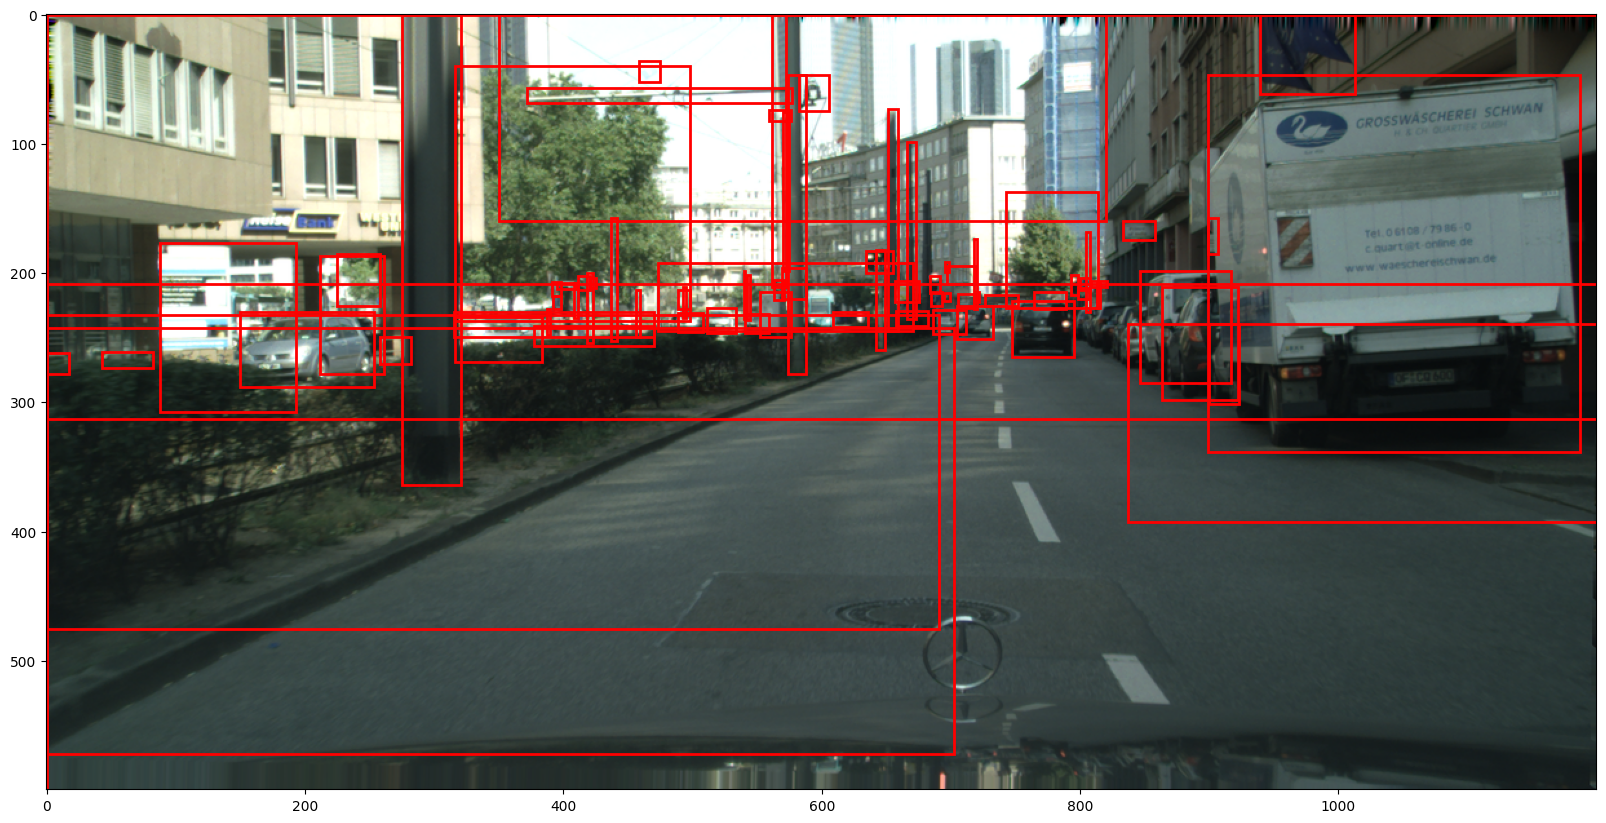

In [36]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img[0]), target[0])

MODEL OUTPUT
tensor([0.3641, 0.2184, 0.2145, 0.2113, 0.2029, 0.1895, 0.1884, 0.1809, 0.1809,
        0.1809, 0.1807, 0.1806, 0.1806, 0.1805, 0.1804, 0.1643, 0.1492, 0.1486,
        0.1318, 0.1008, 0.1008, 0.1008, 0.1007, 0.1007, 0.1006, 0.1006, 0.1005,
        0.0955, 0.0954, 0.0954, 0.0954, 0.0953, 0.0953, 0.0953, 0.0952, 0.0952,
        0.0873, 0.0820, 0.0626, 0.0596, 0.0594, 0.0584, 0.0584, 0.0583, 0.0583,
        0.0583, 0.0583, 0.0583, 0.0583, 0.0582, 0.0570, 0.0569, 0.0552, 0.0511,
        0.0502])


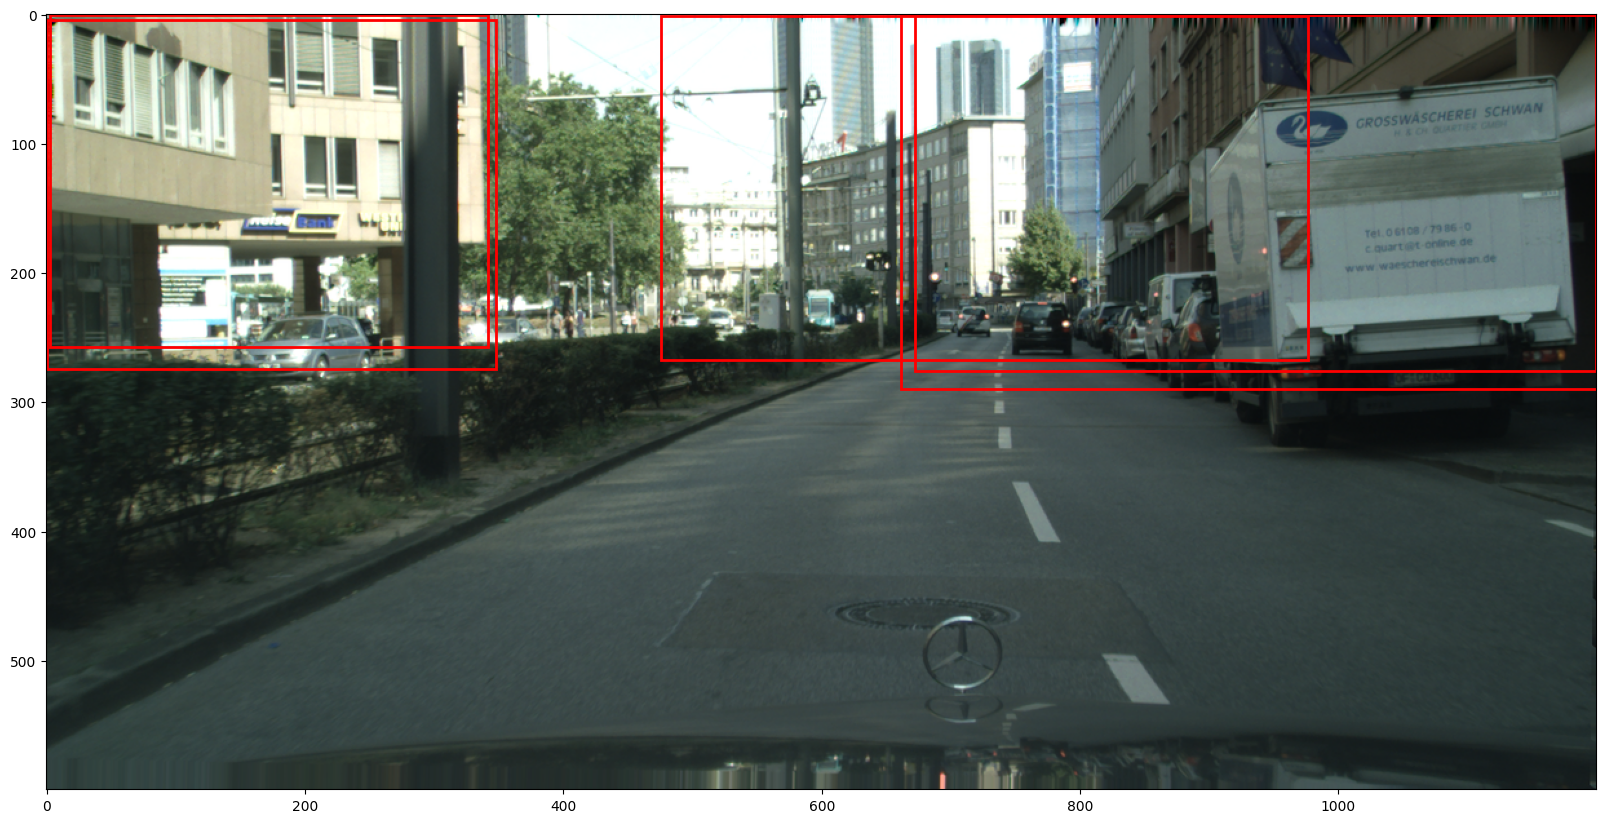

In [38]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img[0]), prediction,score_threshold=0.2)

## Training Process Loss Functions Graph

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the loss data from the CSV file
losses_df = pd.read_csv('Model_Results/Loses_info.csv')

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(losses_df['Train Loss Value'], label='Training Loss', color='blue', marker='o', linestyle='-', linewidth=2)

# Plot validation loss
plt.plot(losses_df['Validation Loss Value'], label='Validation Loss', color='red', marker='x', linestyle='--', linewidth=2)

# Adding title and labels
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
